Using TensorFlow backend.


numpy: 1.13.3
keras: 2.0.8
sklearn: 0.19.1


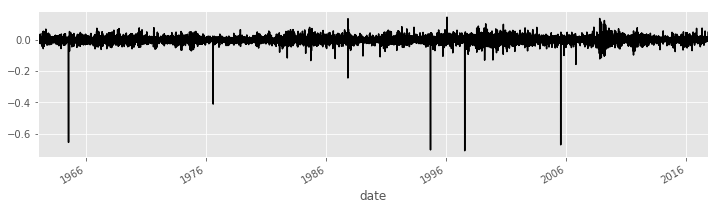

In [1]:
# https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/
# https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf
# https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.wrappers.scikit_learn import KerasRegressor
import sklearn
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
from timeit import default_timer
from data_prep import load_equity

print('numpy: ' + np.__version__)
print('keras: ' + keras.__version__)
print('sklearn: ' + sklearn.__version__)

matplotlib.style.use('ggplot')

cat_df = load_equity('CAT')

plt.figure(figsize=(12,3))
cat_df['lreturn'].plot(style='k-')
plt.show()

In [2]:
# set window size
lookback_length = 1

# fix random seed for reproducibility
seed = 7

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

X, y = create_dataset(cat_df['lreturn'].values[1:], look_back=lookback_length)
print(X.shape)

# save last 5% as test set
t = int(0.05 * len(X))
X_train, X_test = X[:-t,:], X[-t:,:]
y_train, y_test = y[:-t], y[-t:]
print(len(X_train) + len(X_test))

(14048, 1)
14048


In [3]:
def create_lstm_regressor(neurons):
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(1, 1, lookback_length), stateful=True))
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    print(model.summary())
    return model
    
def test_lstm_architecture(neurons):
    start = default_timer()

    estimator = create_lstm_regressor(neurons)

    X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    # fit an LSTM network to training data
    for i in range(200):
        estimator.fit(X_train2, y_train, epochs=1, batch_size=1, verbose=0, shuffle=False)
        estimator.reset_states()
        
    estimator.predict(X_train2, batch_size=1)

    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(y_test)):
        # make one-step forecast
        X, y = X_test2[i, :, :], y_test[i]
        yhat = estimator.predict(X.reshape(1, 1, X.size), batch_size=1)[0,0]
        # store forecast
        predictions.append(yhat)

    print('%0.0f min' % ((default_timer() - start)/60.0))

    # report performance
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print('Test RMSE: %.3f' % rmse)
    # line plot of observed vs predicted
    plt.figure(figsize=(12,6))
    plt.plot(y_test, label='true')
    plt.plot(predictions, label='pred')
    plt.legend()
    plt.show()

    # plot raw predicted values
    y_test_raw = [10000]
    for v in y_test:
        y_test_raw.append(y_test_raw[-1] * np.exp(v))

    pred_raw = [10000]
    for v in predictions:
        pred_raw.append(pred_raw[-1] * np.exp(v))

    plt.figure(figsize=(12,6))
    plt.plot(y_test_raw, label='true')
    plt.plot(pred_raw, label='pred')
    plt.legend()
    plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None
117 min
Test RMSE: 0.016


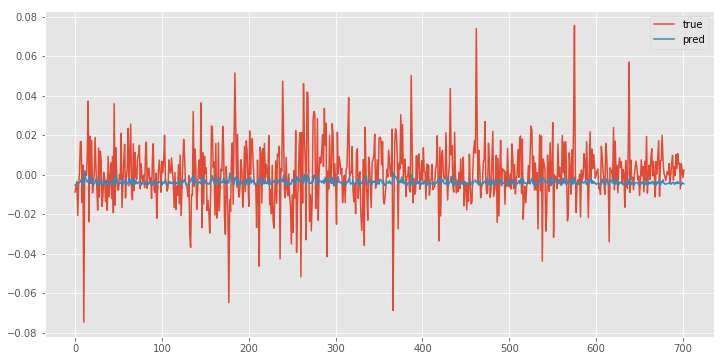

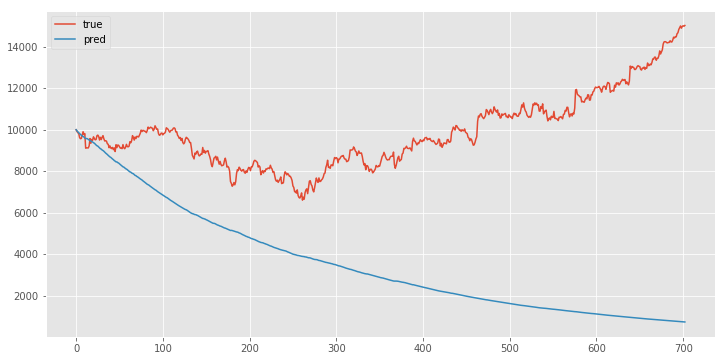

In [4]:
np.random.seed(seed)

test_lstm_architecture(4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 8)                    320       
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
None
104 min
Test RMSE: 0.016


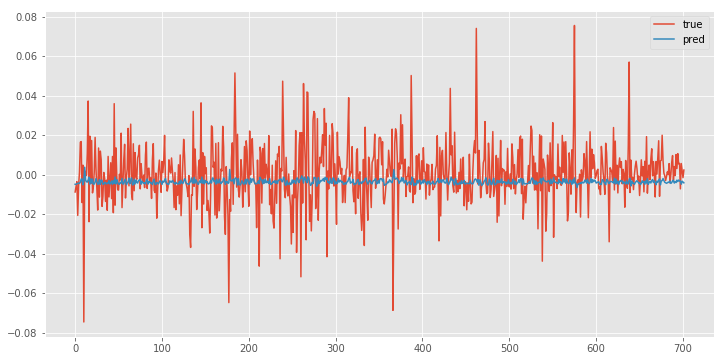

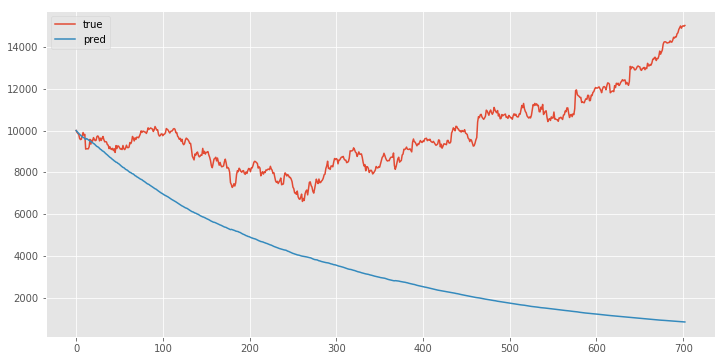

In [5]:
np.random.seed(seed)

test_lstm_architecture(8)